In [1]:
import sys

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import seaborn as sns

sys.path.append('..')
from gpwink2 import GLOBAL_DTYPE
from gpwink2.complex import ComplexGaussian
from gpwink2.inducing import FilterInducingVariable, NoiseInducingVariable
from gpwink2.integrable import GaussianSquareExponentialKernel, GaussianSquareExponentialWindow
from gpwink2.model import GPWiNK
import gpwink.utils as ut

np.random.seed(42)

## Data Generation

In [2]:
num_points = 1001
final = 1000
num_observed = 200
t_data = np.linspace(0, final, num_points)
gram = ut.np_decaying_square_exponential(t_data, alpha=0, gamma=1 / 10 ** 2) + 0.00001 * np.eye(num_points)
data = np.random.multivariate_normal(t_data * 0, gram)
index_observed = np.random.choice(num_points, num_observed)
t_observed = t_data[index_observed]
data_observed = data[index_observed]

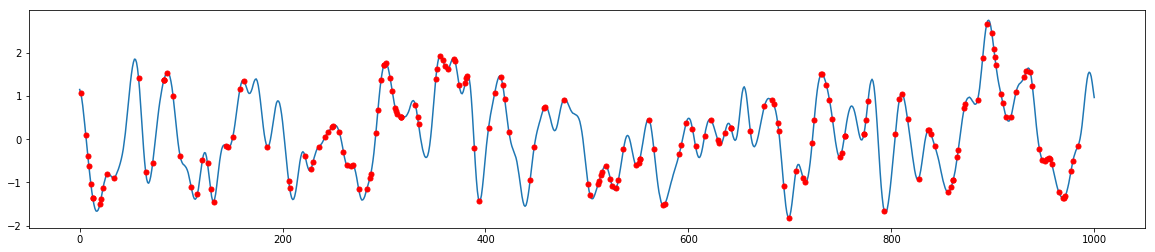

In [3]:
plot=True
if plot:
    fig = plt.figure(figsize=(20, 4))
    plt.plot(t_data, data)
    plt.plot(t_observed, data_observed, '.r', ms=10)
    plt.show()

## Build GPWiNK Model

In [4]:
sess = tf.InteractiveSession()

Set number of inducing variables for $h$ and $x$

In [5]:
nu = 10
nv = 100

Build filter kernel

In [6]:
sigma  = tf.Variable([[1.0]],  dtype=GLOBAL_DTYPE)
gamma  = tf.Variable([[1.0]],  dtype=GLOBAL_DTYPE)
alpha  = tf.Variable([[0.01]], dtype=GLOBAL_DTYPE)
filter_kernel = GaussianSquareExponentialKernel.new_kernel(sigma, gamma, alpha)

Build interdomain inducing variable

In [7]:
# inducing filter
u_locations = np.linspace(-10, 10, nu)[:, None]

sigma   = tf.Variable(np.ones((nu, 1)))
gamma   = tf.Variable(np.ones((nu, 1)))  # np.random.rand(nu, 1) + 0.5,
centre  = tf.Variable(u_locations)
j_omega = tf.Variable(np.ones((nu, 1)), dtype=GLOBAL_DTYPE)
j_phi   = tf.Variable(np.ones((nu, 1)), dtype=GLOBAL_DTYPE)

In [8]:
filter_interdomain_transform  = GaussianSquareExponentialWindow.new_window(sigma, gamma, centre, j_omega, j_phi)
filter_inducing = FilterInducingVariable(
    locations=centre,
    interdomain_transform=filter_interdomain_transform, 
    kernel=filter_kernel 
)

In [9]:
# inducing noise
v_locations = np.linspace(0, final, nv)[:, None]

sigma   = tf.Variable(tf.ones((nv, 1)))
gamma   = tf.Variable(tf.ones((nv, 1)))
centre  = tf.Variable(v_locations)
j_omega = tf.Variable(tf.ones((nv, 1)))
j_phi   = tf.Variable(tf.ones((nv, 1)))

In [10]:
noise_interdomain_transform = GaussianSquareExponentialWindow.new_window(sigma, gamma, centre, j_omega, j_phi)
noise_inducing = NoiseInducingVariable(
    locations=centre, 
    interdomain_transform=noise_interdomain_transform, 
)

Build Variational approximators

In [11]:
# variational u
mean  = tf.Variable(np.ones((nu, 1)) + 10 * np.random.rand(nu, 1)) #+ 1j * np.random.rand(n_u, 1)
alpha = tf.Variable(np.random.rand(nu, nu))
beta  = tf.Variable(np.random.rand(nu, nu))
gamma = tf.Variable(np.random.rand(nu, nu))
delta = tf.Variable(np.random.rand(nu, nu))

filter_variational = ComplexGaussian.from_params(mean, alpha, beta, gamma, delta)

In [12]:
# variational v
mean  = tf.Variable(np.ones((nv, 1)) + 10 * np.random.rand(nv, 1)) #+ 1j * np.random.rand(n_v, 1)
alpha = tf.Variable(np.random.rand(nv, nv))
beta  = tf.Variable(np.random.rand(nv, nv))
gamma = tf.Variable(np.random.rand(nv, nv))
delta = tf.Variable(np.random.rand(nv, nv))

noise_variational = ComplexGaussian.from_params(mean, alpha, beta, gamma, delta)

Create GPWiNK Object

In [13]:
t_observed = tf.convert_to_tensor(t_data[index_observed], dtype=GLOBAL_DTYPE)
data_observed = tf.convert_to_tensor(data[index_observed], dtype=GLOBAL_DTYPE)

gpwink = GPWiNK(
    t_obs=t_observed,
    y_obs=data_observed,
    filter_kernel=filter_kernel,
    filter_inducing=filter_inducing,
    noise_inducing=noise_inducing,
    filter_variational=filter_variational,
    noise_variational=noise_variational
)

In [14]:
elbo = gpwink.build_elbo()

In [15]:
sess.run(tf.global_variables_initializer())

In [16]:
elbo = sess.run(elbo)

UnknownError: LinAlgError: Matrix is not positive definite
	 [[Node: PyFunc_3 = PyFunc[Tin=[DT_FLOAT], Tout=[DT_FLOAT], token="pyfunc_3", _device="/job:localhost/replica:0/task:0/cpu:0"](concat_13/_41)]]
	 [[Node: map_1/while/MatrixSolve_5/_91 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_8529_map_1/while/MatrixSolve_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](^_cloopmap_1/while/transpose_111/Range/_6)]]

Caused by op 'PyFunc_3', defined at:
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-14-b083e92490df>", line 1, in <module>
    elbo = gpwink.build_elbo()
  File "../gpwink2/model.py", line 143, in build_elbo
    build_quadratic_term() + build_kl_divergence_term()
  File "../gpwink2/model.py", line 138, in build_kl_divergence_term
    self.noise_inducing.augmented_covariance()
  File "../gpwink2/kullback_leiblers.py", line 29, in kl_complex_gaussian
    L2 = tf.py_func(np.linalg.cholesky, [c2], c2.dtype)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tensorflow/python/ops/script_ops.py", line 203, in py_func
    input=inp, token=token, Tout=Tout, name=name)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tensorflow/python/ops/gen_script_ops.py", line 36, in _py_func
    name=name)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2630, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/canas/Programs/miniconda/envs/hpc/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1204, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

UnknownError (see above for traceback): LinAlgError: Matrix is not positive definite
	 [[Node: PyFunc_3 = PyFunc[Tin=[DT_FLOAT], Tout=[DT_FLOAT], token="pyfunc_3", _device="/job:localhost/replica:0/task:0/cpu:0"](concat_13/_41)]]
	 [[Node: map_1/while/MatrixSolve_5/_91 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_8529_map_1/while/MatrixSolve_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](^_cloopmap_1/while/transpose_111/Range/_6)]]
